# EDA

In [ ]:
%cd ..

In [1]:
# Standard library imports
import gc

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Third-party imports - pmdarima
from pmdarima import auto_arima

# Third-party imports - statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Local application imports
import src.pre_processing as pre

In [2]:
taxi_orders_df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
hourly_orders = taxi_orders_df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
hourly_orders.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
del taxi_orders_df
del pre.taxi_orders_df

In [5]:
hourly_orders.isna().sum()

num_orders    0
dtype: int64

<Axes: xlabel='datetime'>

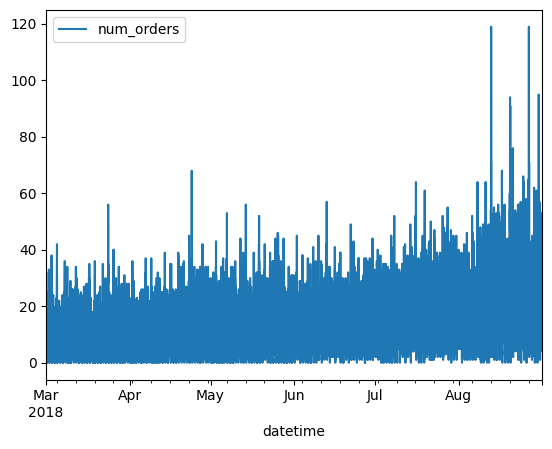

In [6]:
hourly_orders.plot()

In [7]:
result = adfuller(hourly_orders)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -12.548885000267546
p-value: 2.2286378815479297e-23


A p-value of .03 means that we can reject the null hypothesis that our data has a unit root (and therefore lacks stationarity). This means that no differencing is required. 

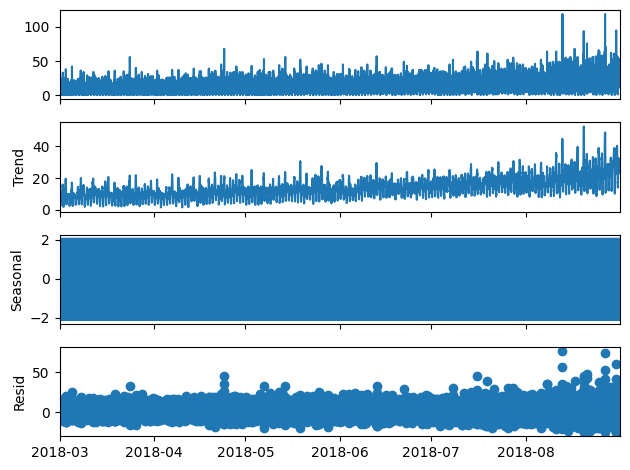

In [8]:
decomposition = seasonal_decompose(hourly_orders, model='additive', period=24)
fig = decomposition.plot()

Okay, our data exhibits a mild trend toward increased taxi use which likely results from increasingly nice weather. The the smymetrical data with regular fluctions between periods suggests seasonality as well. Let's get a closer look to confirm. 

<Axes: title={'center': 'Two weeks of Orders'}, xlabel='datetime'>

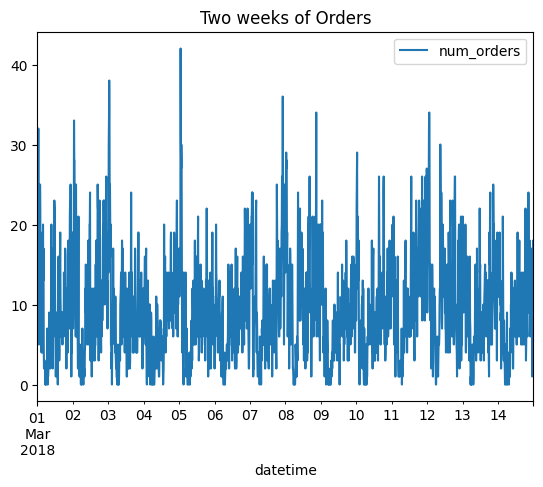

In [9]:
one_week = hourly_orders['2018-03-01': '2018-03-14']
one_week.plot(title='Two weeks of Orders')

As we suspected from our plot of the full data set, the above plot confirms that our data exhibits daily seasonality. It also suggests there may be some mild weekly seasonality (see for example 02-05 and 09-12). Therefore, we will add some lag features to pick up on these patterns. 

In [10]:
del hourly_orders 
del pre.hourly_orders
del pre.train_hour
del pre.test_hour
del pre.train_12_hours
del pre.test_12_hours
del pre.train_day
del pre.test_day
del pre.train_3_days
del pre.test_3_days
del pre.train_week
del pre.test_week

Our first plot of the data showed daily seasonality, and since the unit of time we are interested in predicting value for is hours we will define one season as being 24 hours. 

In [11]:

def pacf_acf(s: int, target_train: pd.Series, forecast_length: str) -> None:

    # Plot PACF for up to 7 seasonal cycles (7 * s lags)
    max_lag = 31 * s

    fig, ax = plt.subplots(2, 1, figsize=(12,8))

    # PACF plot
    plot_pacf(pre.y_train_hour, lags=max_lag, ax=ax[0])
    ax[0].set_title(f'{forecast_length} Forecast Partial Autocorrelation Function (PACF)')

    # ACF plot (useful for seasonal MA terms)
    plot_acf(target_train, lags=max_lag, ax=ax[1])
    ax[1].set_title(f'{forecast_length} Forecast Autocorrelation Function (ACF)')

    plt.tight_layout()
    plt.show()

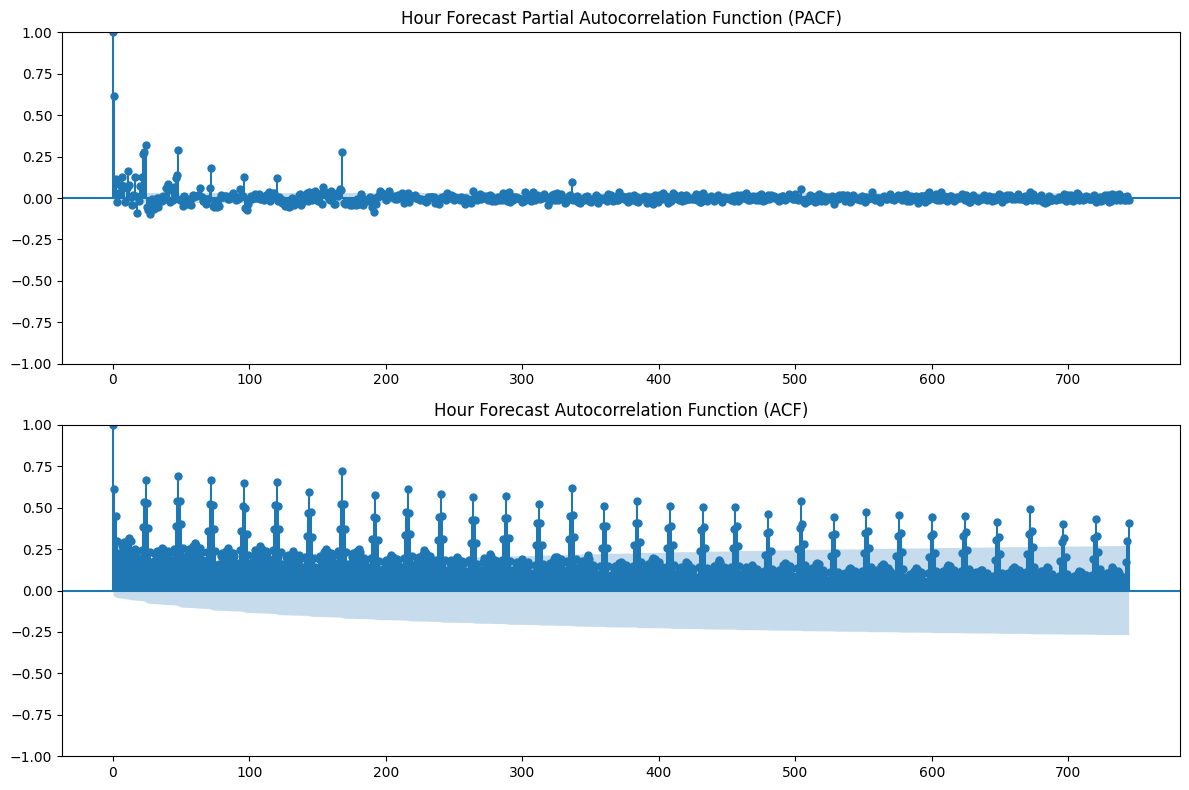

In [12]:
pacf_acf(24, pre.y_train_hour, 'Hour')

Even though y_train_hour and y_train_12_hours are the same data, we include y_train_12_hours here to align with the rest of the pipeline. This way if someone decides to make a change to y_train_12_hours, no further changes will need to be made to the code in this notebook. 

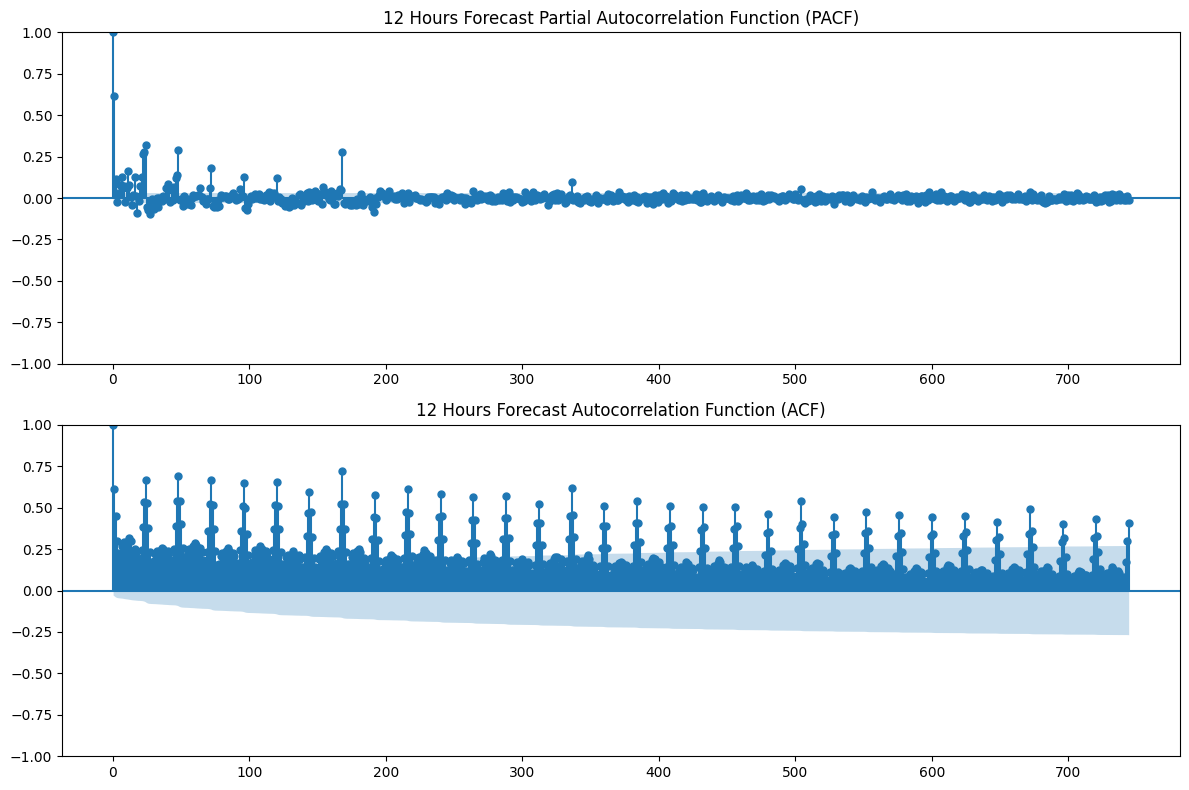

In [13]:
pacf_acf(24, pre.y_train_12_hours, '12 Hours')

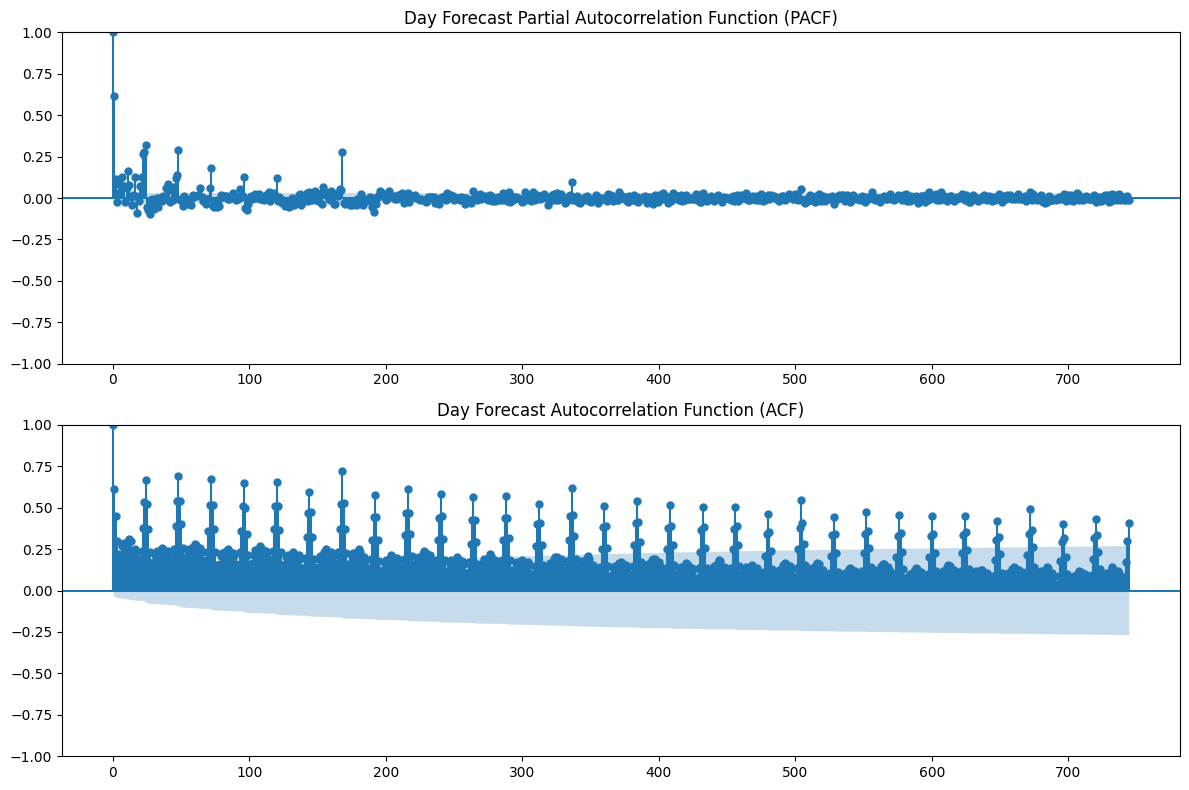

In [14]:
pacf_acf(24, pre.y_train_day, 'Day')

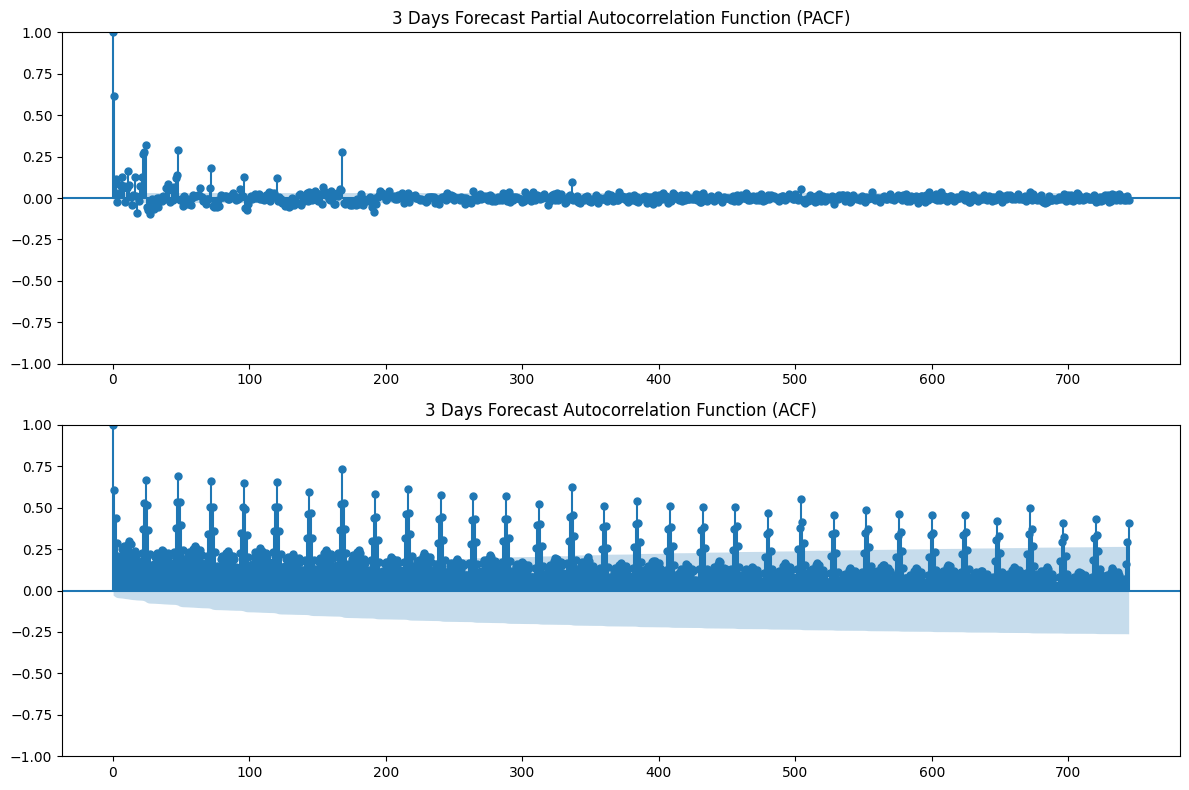

In [15]:
pacf_acf(24, pre.y_train_3_days, '3 Days')

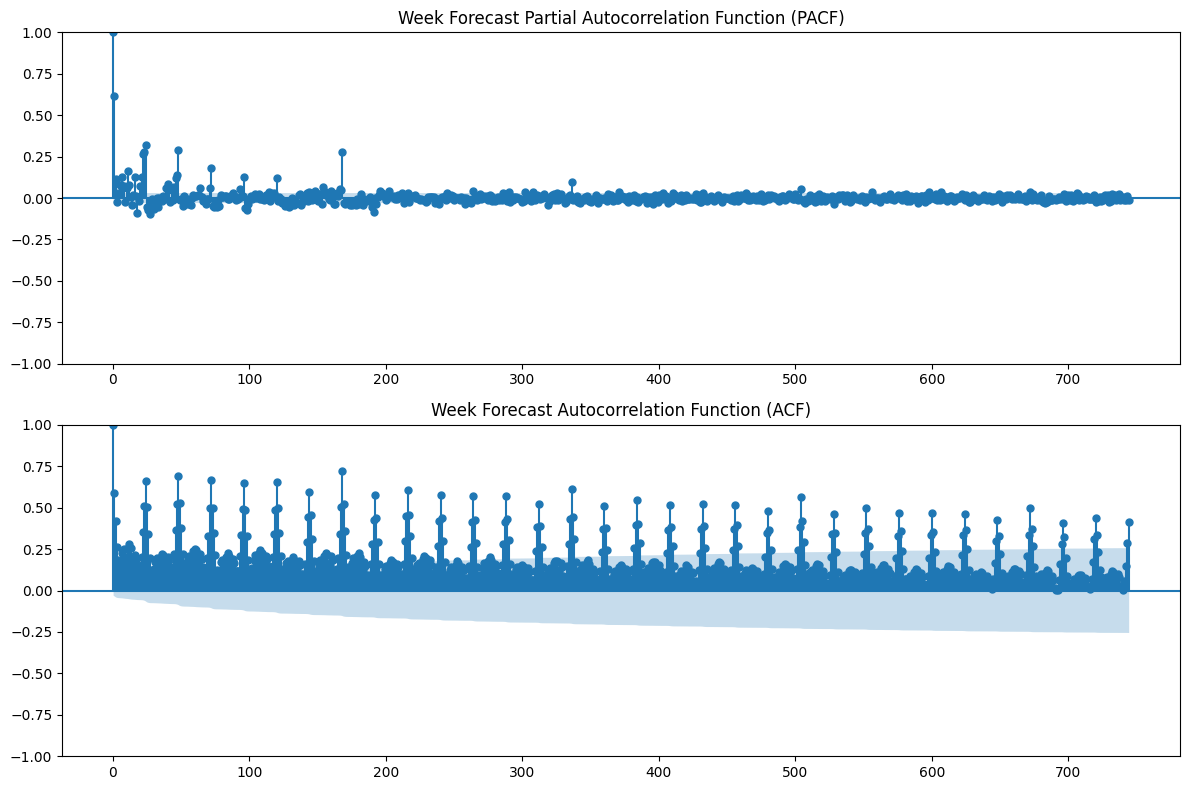

In [16]:
pacf_acf(24, pre.y_train_week, 'Week')

Given that we are working with nearly identical training sets (differing only in how much was left from the full set when the test set was taken out), it was a little bit of a formality to plot ACF and PACF plots for each training set. However, while it would have been unexpected to find differences between the training set targets, any differences that were there would have been worth knowing about. Nevertheless, as you can see there is almost no difference between the plots from the respective data sets. Both the PACF and ACF plots show big spikes at 24 hour intervals, reflecting the data's strong daily seasonality. 

The seven spikes above the confidence intervals in our PACF plot suggest that we should try a p value of 7. In fact, the plot suggests that we could try more, but we don't want our model to take forever to fit. There do not appear to be any siginficant drop offs in our ACF plot, which suggests a q value of 0 is appropriate. That is, we will not make a moving average adjustment on the order level. Our adfuller test suggested that our data did not have any trend. However, our decomposed plot seems to show a mild upward trend in taxi usage, and there is a tiny downward trend in the ACF plots which reflects a mild decrease in correlation between lag values near the present and lag values from the distant past. This suggests a value of 1 for d might be appropriate. The seasonal peaks in the PACF plot suggest a P value as high as 7 would be appropriate. However, after the first seasonaly period of 24 hours, the plot doesn't reach that peak again until 168 hours. For the sake of time and computational efficiency, therefore, we will set P to 1. There are no signifcant spikes or drops at seasonal intervals on the PACF plot so we can likely keep D and Q at zero. As we have already discussed, we are working with daily seasonality, so we will set m to 24. The hyperparameters for thos SARIMA model are set in models.py in the src folder. 